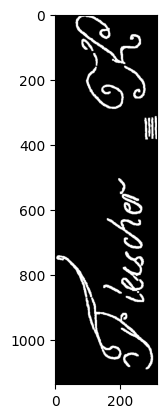

In [13]:
import sys
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt 
from skimage import morphology
import math



def preprocess_drawing(image: ndarray):
  def remove_blobs(image, min_size):
    # Variables image, min_size
    # image: image we want to remove the small blobs
    # min_size: minimum size of particles we want to keep

    # find all of the connected components (white blobs in your image).
    nb_blobs, im_with_separated_blobs, stats, _ = cv.connectedComponentsWithStats(image)
    # we are interested only in the size of the blobs, contained in the last column of stats.
    sizes = stats[:, -1]
    # take out background which is also considered a component
    sizes = sizes[1:]
    nb_blobs -= 1

    # create output image with only the kept components
    img_result = np.zeros_like(im_with_separated_blobs)
    # for every component in the image, keep it only if it's above min_size
    for blob in range(nb_blobs):
        if sizes[blob] >= min_size:
            # see description of im_with_separated_blobs above
            img_result[im_with_separated_blobs == blob + 1] = 255
    # return proccessed image        
    return img_result

  def find_horizontal_lines(image):
    # create the images that will use to extract the horizontal and vertical lines
    horizontal = np.copy(image)
    # specify size on horizontal axis
    cols = horizontal.shape[1]
    horizontal_size = cols // 30
    # create structure element for extracting horizontal lines through morphology operations
    horizontalStructure = cv.getStructuringElement(cv.MORPH_RECT, (horizontal_size, 1))
    # apply morphology operations
    horizontal = cv.erode(horizontal, horizontalStructure)
    horizontal = cv.dilate(horizontal, horizontalStructure)

    # Smooth horizontal lines in 5 steps
    horizontal = cv.bitwise_not(horizontal)
    # step 1: extract edges
    edges = cv.adaptiveThreshold(horizontal, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 3, -2)
    # step 2: dilate(edges)
    kernel = np.ones((2, 2), np.uint8)
    edges = cv.dilate(edges, kernel)
    # step 3: src.copyTo(smooth)
    smooth = np.copy(horizontal)
    # step 4: blur smooth img
    smooth = cv.blur(smooth, (2, 2))
    # step 5: smooth.copyTo(src, edges)
    (rows, cols) = np.where(edges != 0)
    horizontal[rows, cols] = smooth[rows, cols]
    horizontal = cv.bitwise_not(horizontal)

    # return horizonzal lines
    return horizontal


  def remove_short_lines(image, min_length=None):
    # Variables image, min_size
    # image: image we want to remove the short conturs
    # min_length: minimum lenth of conturs we want to keep, default is 0.3 of image width
    
    # create new varaible to store the intermediate horizontal lines
    lines_contour = image.astype('uint8')

    # If no minimal length was specified set it to be 30% of the length of the image
    if min_length is None:
        h, w = lines_contour.shape
        min_length = (2*w*0.3)

    # get conturs from horizontal image
    contours, hierarchy = cv.findContours(lines_contour, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    # keep all contours that are at least the length of min_length
    for i, c in enumerate(contours):
        length_tresh = min_length
        length = cv.arcLength(c,True)
        if length < length_tresh:  # Fill small contours with black color
            cv.drawContours(lines_contour, contours, i, 0, cv.FILLED)
    # return imaage with short lines removed
    return lines_contour

  def erode_and_dilate(image):
    # change image format 
    img_erode = image.astype('uint8')
    # creating kernel for erosion
    kernel = np.ones((3, 3), np.uint8)
    # using cv2.erode() method 
    image = cv.erode(img_erode, kernel) 
    # displaying the image 
    plt.imshow(img_erode, cmap='gray')
    # creating kernel for diltution
    kernel = np.ones((5, 5), np.uint8)
    # using cv2.dilate() method 
    img_dilation = cv.dilate(image, kernel, iterations=1)
    # return processed image
    return img_dilation
  
  # rotate image
  img=cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

  # transform source image to gray if it is not already
  if len(img.shape) != 2:
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  else:
    gray = img

  # apply adaptiveThreshold at the bitwise_not of gray
  gray = cv.bitwise_not(gray)
  bw = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 15, -2)
  ret,bw = cv.threshold(bw,10,255,cv.THRESH_BINARY)

  # remove small blobs from image 
  im_result = remove_blobs(bw,150)
  im_result = im_result.astype('uint8')

  # extract horizontal lines
  hor_lines = find_horizontal_lines(im_result)

  # remove small blobs horizontal lines
  hor_lines = remove_blobs(hor_lines,400)

  # remove short horizontal lines
  im_result_hor = remove_short_lines(hor_lines)

  # combine the images
  im_combined = abs(im_result - im_result_hor)
  im_combined = cv.normalize(src=im_combined, dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)

  # remove small combined image 
  im_combined = remove_blobs(im_combined,140)

  # erode and dilate final image
  contours, hierarchy = cv.findContours(im_combined.astype('uint8'), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
  if len(im_combined) > 200:
    final_result = erode_and_dilate(im_combined)
  else :
    final_result = im_combined
    
  # set up return value  
  image = final_result

  return final_result








# path
# path = '/content/0000633_1_h.jpg'
#path = '/content/0001043_1_h.jpg'
#path = '/content/0027086_1_h.png'
#path = '/content/0028010_1_h.jpg'
#path = '/content/0028039_1_h.jpg'
path = '/content/0028054_1_h.jpg'
#path = '/content/0028615_1_h.jpg'

# read image using cv2.imread() method
img = cv.imread(path,0)

# plt.imshow(img, cmap='gray')
res = preprocess_drawing(img)
plt.imshow(res, cmap='gray')
